<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/Proyecto/Adsorcion%20en%20superficies%20basado%20en%20RIUS%20V%201.0%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primera versión del intento de simulación de adsorción basado en el algoritmo de RIUS para pegar iones a superficies



# Hamiltoniano del sistema basico basado en el potencial de lennard-jones

$$ \textit{H}\left ( r_{ij} \right ) = 4\epsilon \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right] $$

#Factor de regularización para asegurar una energía negativa en el aprendizaje no supervisado
$$ \textit{R}\left ( r_{ij} \right ) =  \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right]  $$

# Para asegurar que la energía sea negativa, basta con asegurar que la sección que involucra la distancia sea negativa

# Librerias y Constantes

In [1]:
#Importamos ls librerias necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
#Definimos las constantes a utilizar
a = 7.9 #Parametro de red (A)
SigmaAl = 3.302 #Radio de vanderwalls del aluminio (A)
EpsilonAl = 4.806e+16 #Fondo del pozo del aluminio (ev/mol)
SigmaHg = 2.79 #Radio de vanderwalls del mercurio (A)
EpsilonHg = 6.261482e+22 #Fondo del pozo mercurio (ev/mol)
Sigma = np.sqrt(SigmaAl*SigmaHg)
Epsilon = np.sqrt(EpsilonAl*EpsilonHg)

# Creación de la muestra

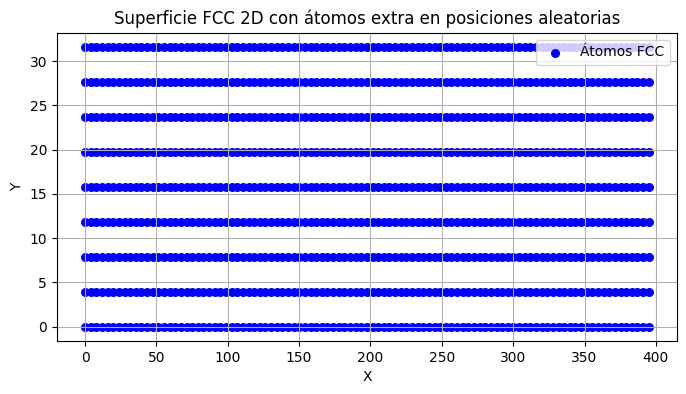

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensiones de la red FCC
celdas_largo = 50
celdas_alto = 4
a = 7.9  # Longitud de la celda unitaria

# Definir los vectores base de una celda unitaria FCC
base_fcc = np.array([[0, 0], [0.5, 0], [0, 0.5], [0.5, 0.5]]) * a

# Crear las posiciones para las celdas unitarias
x, y = [], []
for i in range(celdas_largo):
    for j in range(celdas_alto):
        # Posiciones de átomos en cada celda FCC
        atoms = base_fcc + np.array([i * a, j * a])
        x.extend(atoms[:, 0])
        y.extend(atoms[:, 1])

# Agregar átomos adicionales en la última fila y columna
# Última columna
for j in range(celdas_alto):
    x.append(celdas_largo * a)
    y.append(j * a + 0)  # Átomo en el vértice
    x.append(celdas_largo * a)
    y.append(j * a + 0.5 * a)  # Átomo en el centro de la cara

# Última fila
for i in range(celdas_largo):
    x.append(i * a + 0)
    y.append(celdas_alto * a)
    x.append(i * a + 0.5 * a)
    y.append(celdas_alto * a)

# Añadir el átomo del vértice superior derecho
x.append(celdas_largo * a)
y.append(celdas_alto * a)

fcc_positions = np.column_stack((x, y))  # Matriz con posiciones FCC
num_atoms =fcc_positions.shape[0]
# Graficar la estructura FCC con átomos adicionales
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

# Creación de los iones que se van a adsorber

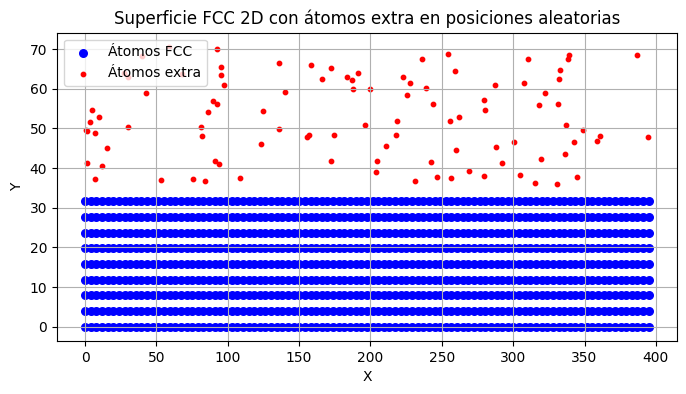

In [31]:
num_atomos_extra = 100  # Número de átomos extra que se colocarán al azar

# Generar átomos adicionales en posiciones aleatorias por encima de la superficie
x_extra = np.random.uniform(0, celdas_largo * a, num_atomos_extra)
y_extra = np.random.uniform(celdas_alto * a + 0.5*a, celdas_alto * a + 5*a, num_atomos_extra)  # Y mayor que la parte más alta
extra_positions = np.column_stack((x_extra, y_extra))  # Matriz con posiciones de átomos extra

# Graficar las posiciones
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.scatter(extra_positions[:, 0], extra_positions[:, 1], color='red', s=10, label="Átomos extra")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
@tf.function
# Potencial de Lennard-Jones
def lennard_jones_potential(r, epsilon=Epsilon, sigma=Sigma):
    """
    Calcula el potencial de Lennard-Jones para una distancia r.
    """
    sigma = tf.cast(sigma, tf.float32)
    epsilon = tf.cast(epsilon, tf.float32)
    lj_term = (sigma / r)**12 - (sigma / r)**6
    return 4 * epsilon * lj_term

# Función de costo para el modelo
def H_loss(Xh, Xt, epsilon=Epsilon, sigma=Sigma,lam_=1.0):
    """
    Calcula la energía total de las interacciones entre los iones (Xh) y la superficie (Xt),
    utilizando el potencial de Lennard-Jones.

    Parameters:
        Xh: tensor con posiciones de los iones (num_iones, 2)
        Xt: tensor con posiciones de los átomos de la superficie (num_superficie, 2)

    Returns:
        Energía promedio del sistema (escalar)
    """
    # Expandir dimensiones para obtener todas las combinaciones de distancias
    diff = tf.expand_dims(Xh, axis=1) - tf.expand_dims(Xt, axis=0)  # (num_iones, num_superficie, 2)
    r = tf.norm(diff, axis=-1)  # Distancia entre cada ion y cada átomo de la superficie (num_iones, num_superficie)

    # Evitar divisiones por cero
    r = tf.where(r == 0, 1e-10, r)

    # Calcular el potencial de Lennard-Jones para cada interacción
    lj_energy = lennard_jones_potential(r, epsilon, sigma)  # (num_iones, num_superficie)
    reg_term = tf.reduce_sum(lj_energy/4*epsilon,axis=1)
    # Energía total para cada ion
    E_total = tf.reduce_sum(lj_energy, axis=1)  # Suma sobre los átomos de la superficie (num_iones)

    # Devolver la energía promedio del sistema
    energy_total = tf.reduce_mean(lam_*E_total+(1-lam_)*reg_term)  # Promedio sobre los iones (escalar)

    return energy_total

In [34]:
#tensorflow data
Xh = tf.convert_to_tensor(extra_positions,dtype=tf.float32)
Xt = tf.convert_to_tensor(fcc_positions,dtype=tf.float32)
lam_LJ = 0.4
lam_ = tf.constant(lam_LJ,dtype=tf.float32)


In [35]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

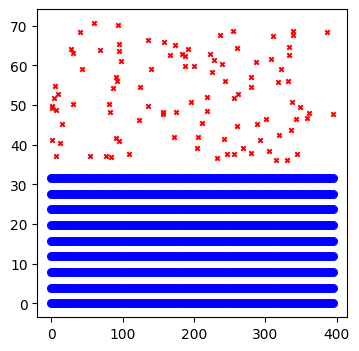

Epoch 1/50
Loss: -0.0024961214512586594 MeanGrad: [3.8398753e-07 2.3103454e-05]


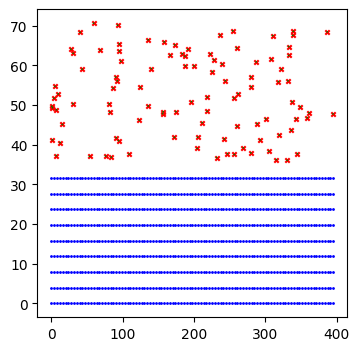

Epoch 2/50
Loss: -0.0010566479759290814 MeanGrad: [-7.8315429e-07  7.5643793e-06]


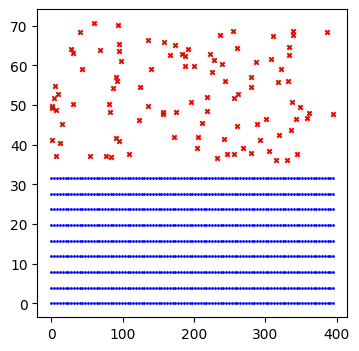

Epoch 3/50
Loss: -0.0020090951584279537 MeanGrad: [6.7885312e-06 1.6278482e-05]


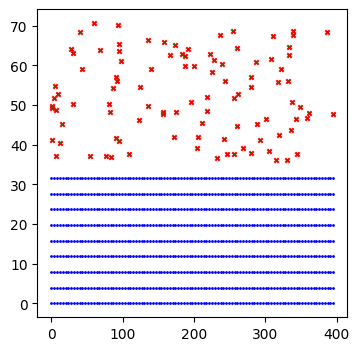

Epoch 4/50
Loss: -0.0021836194209754467 MeanGrad: [4.5556899e-06 1.8439176e-05]


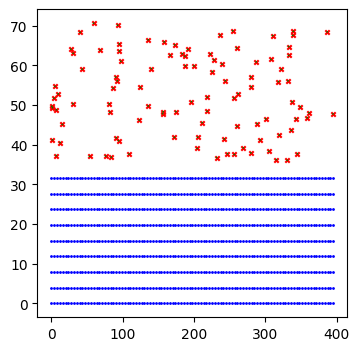

Epoch 5/50
Loss: -0.0009622196666896343 MeanGrad: [-1.6801150e-07  6.1866745e-06]


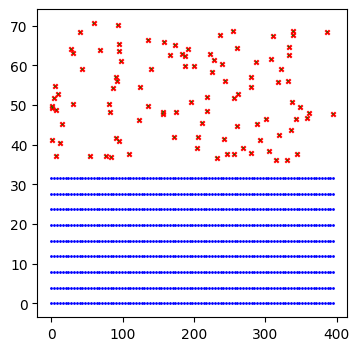

Epoch 6/50
Loss: -0.0019979693461209536 MeanGrad: [3.4662664e-06 1.6960326e-05]


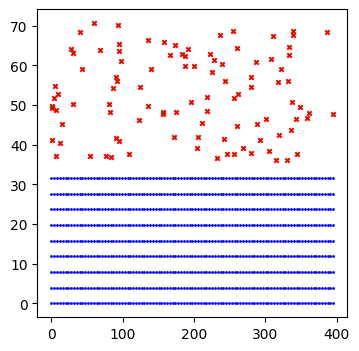

Epoch 7/50
Loss: -0.0017269380623474717 MeanGrad: [1.7514212e-06 1.3155264e-05]


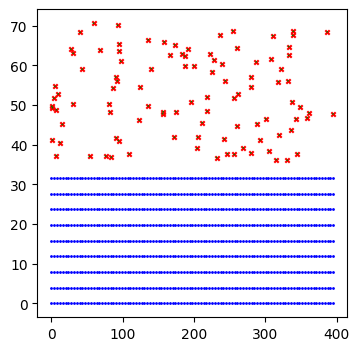

Epoch 8/50
Loss: -0.0013180312234908342 MeanGrad: [1.3929063e-06 1.0249052e-05]


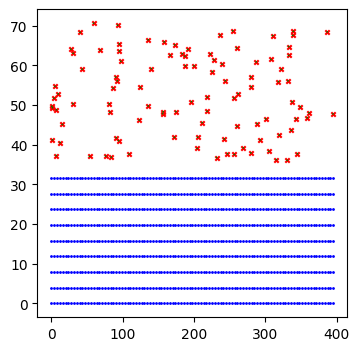

Epoch 9/50
Loss: -0.001978629967197776 MeanGrad: [3.2533740e-06 1.7494182e-05]


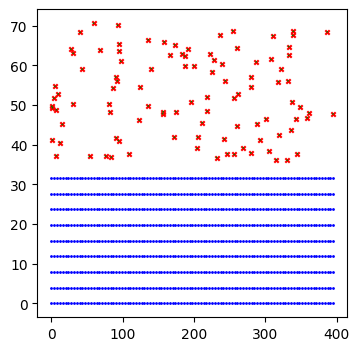

Epoch 10/50
Loss: -0.0009161820053122938 MeanGrad: [1.9148273e-07 5.8815986e-06]


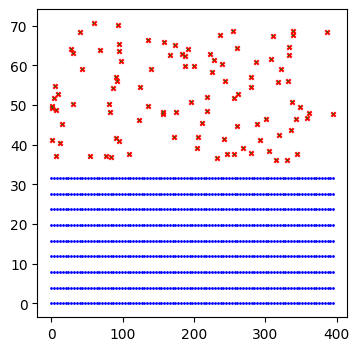

Epoch 11/50
Loss: -0.0005411111633293331 MeanGrad: [2.4976094e-07 2.9337646e-06]


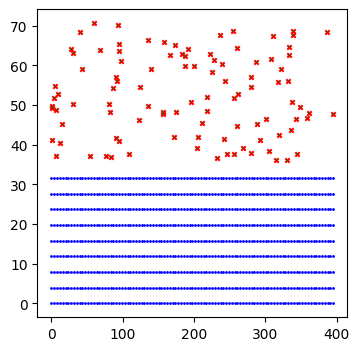

Epoch 12/50
Loss: -0.0012346712173894048 MeanGrad: [2.5707445e-06 9.0394096e-06]


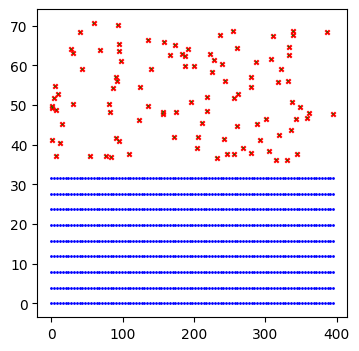

Epoch 13/50
Loss: -0.0029408494010567665 MeanGrad: [4.1000726e-06 2.4628978e-05]


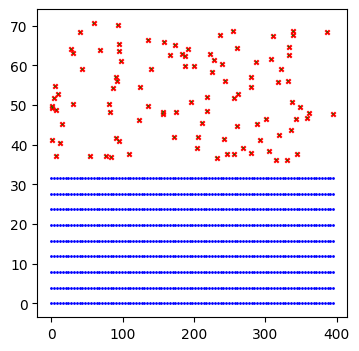

Epoch 14/50
Loss: -0.00318893906660378 MeanGrad: [-2.9875287e-06  3.0605694e-05]


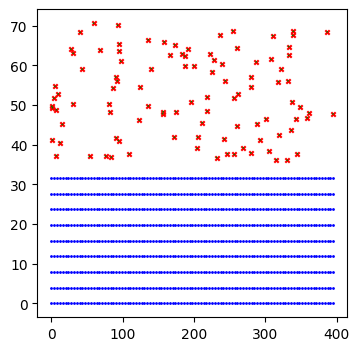

Epoch 15/50
Loss: -0.0006278319051489234 MeanGrad: [1.3327241e-06 4.5043726e-06]


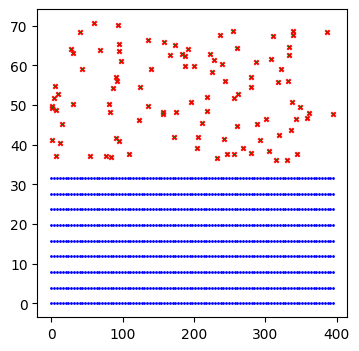

Epoch 16/50
Loss: -0.0007296976400539279 MeanGrad: [7.4341779e-07 5.0853896e-06]


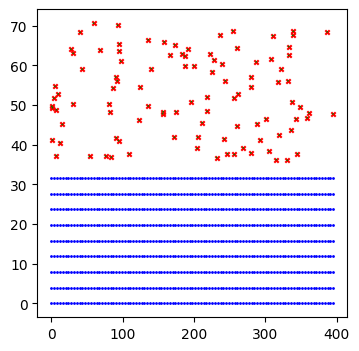

Epoch 17/50
Loss: -0.0010830276878550649 MeanGrad: [1.5143507e-06 7.6955130e-06]


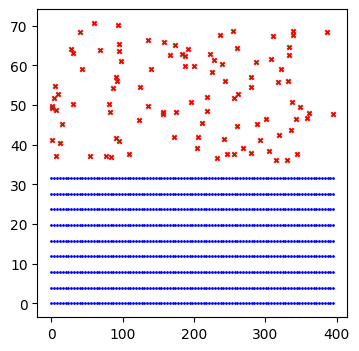

Epoch 18/50
Loss: -0.002196412766352296 MeanGrad: [1.6351894e-06 1.8270073e-05]


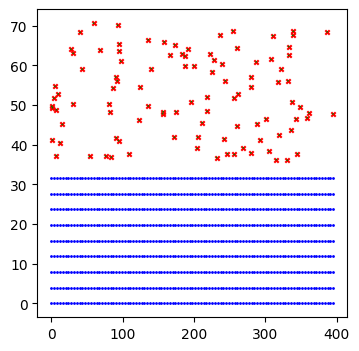

Epoch 19/50
Loss: -0.0021778023801743984 MeanGrad: [6.7813596e-07 1.8489887e-05]


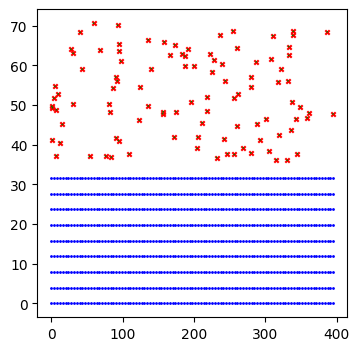

Epoch 20/50
Loss: -0.0017397589981555939 MeanGrad: [-8.2963010e-07  1.4148121e-05]


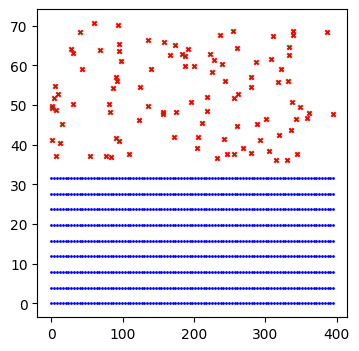

Epoch 21/50
Loss: -0.0015464540338143706 MeanGrad: [3.6043576e-07 1.2114695e-05]


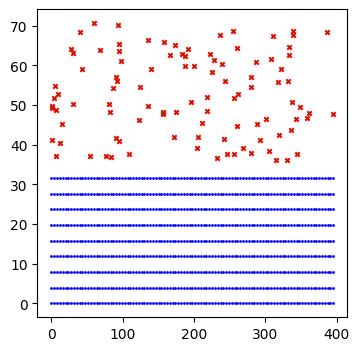

Epoch 22/50
Loss: -0.0018386549782007933 MeanGrad: [1.0532149e-06 1.4243814e-05]


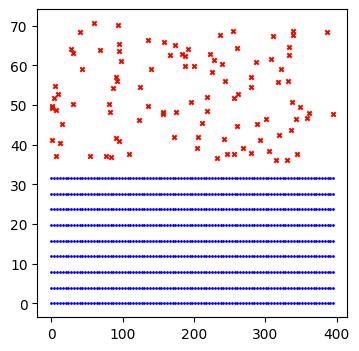

Epoch 23/50
Loss: -0.0015092650428414345 MeanGrad: [-3.5787164e-06  1.4179762e-05]


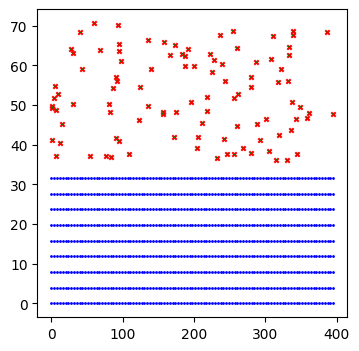

Epoch 24/50
Loss: -0.00201506563462317 MeanGrad: [2.0473890e-06 1.6780268e-05]


KeyboardInterrupt: 

ValueError: Image size of 87335x86857 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 400x400 with 1 Axes>

In [36]:
Xh_ =  Xh.numpy()
plt.figure(figsize=(4,4))
plt.scatter(fcc_positions[:,0],fcc_positions[:,1],c = 'b',s=30)
plt.scatter(Xh_[:,0],Xh_[:,1],c = 'r',s=10,marker='x')
plt.show()
# Custom training loop
eta0 = 1e-1
batch_size = 256
epochs = 50
decay_rate = 0.95

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    for x_batch in tf.data.Dataset.from_tensor_slices(Xt).shuffle(buffer_size=1024).batch(batch_size):

      with tf.GradientTape() as g:
        g.watch(Xh)
        H_loss_ = H_loss(Xh,x_batch,lam_)
      grad_ = g.gradient(H_loss_, Xh)
      Xh = Xh -eta*grad_
    print(f'Loss: {H_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    Xh_ =  Xh.numpy()
    gradN = -10*eta*grad_.numpy()


    plt.figure(figsize=(4,4))
    plt.scatter(fcc_positions[:,0],fcc_positions[:,1],c = 'b',s=1)
    plt.scatter(Xh_[:,0],Xh_[:,1],c = 'r',s=10,marker='x')
    plt.quiver(Xh_[:,0],Xh_[:,1], gradN[:,0], gradN[:,1], color='g', scale=1, scale_units='xy', angles='xy', label='Gradient Vectors')
    plt.show()

# Tareas Luker - Sofia y Juan Lugo


## Unsupervised Deep Embedding for Clustering Analysis

https://proceedings.mlr.press/v48/xieb16.pdf

https://github.com/HaebinShin/dec-tensorflow


## Tareas Sofia:

Revisar matemática PRI

Revisar Paper Unsupervised Deep Embedding for Clustering Analysis

Implementar DEC según github compartido y aplicar sobre experimento de goku y sobre Fashion Mnist

## Tareas Juan Lugo

Revisar modelo tabnet

https://paperswithcode.com/method/tabnet

Revisar implementaciones sobre keras

https://github.com/jeyabbalas/tabnet

Aplicar sobre base de datos fifa19 curso aprendizaje de máquina para luego aplicar a Luker

## Objetivo luker

- Unir DCE/PRI sofia con Tabnet Lugo, con modelo generativo para lidear con generación de propiedades físico químicas desde espacio latente anotadores

## Tareas sofia y lugo

Revisar focal loss para lidear con datos desbalanceados

https://paperswithcode.com/method/focal-loss